# Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Funciones

### Función para generar nuevos boletos aleatorios

In [2]:
def randomgen():

    numero = rd.sample(range(1,50),7)
    complementario = rd.sample(numero,1)
    numero.remove(complementario[0])
    reintegro = rd.sample(range(10),1)
    
    numero.sort()

    combo = {}
    combo['numero'] = numero
    combo['reintegro'] = reintegro

    return combo

### Función para generar nuevos boletos teniendo en cuenta la distribución de la muestra histórica

In [26]:
def frequencygen(df, exp=3):
    #obtengo las números sacados en orden cronológico
    tiradas = []
    for row in df.index:
        for n in df.loc[row,'1':'6']:
            tiradas.append(n)
    tiradas = pd.Series(tiradas)

    #obtengo la frecuencia de muestreo de cada número
    freqs = tiradas.value_counts()
    #si algún número no ha salido en la muestra, lo añado
    for i in range(1,50):
        if not i in freqs.index:
            freqs[i] = 0
    #los ordeno por el índice
    freqs = freqs.sort_index()

    #obtengo la desviación de la frecuencia de cada número respecto a la frecuencia media
    desviacion = freqs-freqs.mean()
    #invierto la frecuencia para que esté en el signo correcto
    i_desviacion = -desviacion
    #obtengo la probabilidad histórica de cada número, y genero una lista con tantas repeticiones por número como probabilidades tenga
    probs = (i_desviacion/len(tiradas))/2
    probs *= np.pi
    probs = np.tan(probs)
    adding = np.round((np.abs(probs)**(1/exp))*(probs/np.abs(probs))*100,0)

    #esta es la lista
    ruleta = []
    for i in range(1, 50):
        ns = int(100 + adding[i])
        for n in range(ns):
            ruleta.append(i)

    #obtengo una combinación eligiendo números aleatorios de la lista
    numeros = []
    for i in range(6):
        numeros.append(rd.sample(ruleta, 1)[0])
        indexes = np.where(np.array(ruleta)==numeros[-1])[0].tolist()
        ruleta = ruleta[:indexes[0]] + ruleta[(indexes[-1]+1):]
    numeros.sort()

    #obtengo las frecuencias históricas de los reintegros y añado los que no hayan salido en el histórico
    freqs = df.R.value_counts()
    for i in range(10):
        if not i in freqs.index:
            freqs[i] = 0
    freqs = freqs.sort_index()
    #obtengo la desviación de la frecuencia de cada número con respecto a la frecuencia media
    desviacion = freqs-freqs.mean()
    #lo invierto para que esté bien el signo
    i_desviacion = -desviacion
    
    #obtengo la probabilidad de cada número, y genero una lista con tantas repeticiones del número como probabilidades tenga
    probs = (i_desviacion/len(df.R))/2
    probs *= np.pi
    probs = np.tan(probs)
    adding = np.round((np.abs(probs)**(1/exp))*(probs/np.abs(probs))*100,0)

    #esta es la lista
    ruleta = []
    for i in range(10):
        ns = int(100 + adding[i])
        for n in range(ns):
            ruleta.append(i)

    #escojo un número aleatorio de la lista generada
    reintegro = rd.sample(ruleta, 1)

    #genero la respuesta de la función
    boleto = {
        'numero':numeros,
        'reintegro':reintegro
    }

    return boleto

### Función de comprobación del premio dado un boleto y la combinación ganadora

In [4]:
def check_primitiva(boleto, sorteo):

    n_match = 0
    for n in boleto['numero']:
        if n in sorteo['numero']:
            n_match+=1

    r_match = boleto['reintegro'] == sorteo['reintegro']

    premio = '0'

    if n_match == 6 and r_match:
        premio = 'E'
    elif n_match == 6:
        premio = '1'
    elif n_match == 5 and sorteo['complementario'][0] in boleto['numero']:
        premio = '2'
    elif n_match == 5:
        premio = '3'
    elif n_match == 4:
        premio = '4'
    elif n_match == 3:
        premio == '5'
    elif r_match:
        premio = 'R'

    return premio

# Simulación

### Obtención de datos históricos de la primitiva y homogeneización

In [5]:
path13_22='https://docs.google.com/spreadsheets/d/e/2PACX-1vTov1BuA0nkVGTS48arpPFkc9cG7B40Xi3BfY6iqcWTrMwCBg5b50-WwvnvaR6mxvFHbDBtYFKg5IsJ/pub?gid=1&single=true&output=csv'
path85_12='https://docs.google.com/spreadsheets/d/e/2PACX-1vTov1BuA0nkVGTS48arpPFkc9cG7B40Xi3BfY6iqcWTrMwCBg5b50-WwvnvaR6mxvFHbDBtYFKg5IsJ/pub?gid=0&single=true&output=csv'

file2 = pd.read_csv(path13_22)
file2 = file2.set_index('FECHA')
file2 = file2.iloc[:,:-1]
file2.columns = ['1','2','3','4','5','6','C','R']

file1 = pd.read_csv(path85_12)
file1 = file1.set_index('FECHA')
file1 = file1.iloc[:,:-1]
file1.columns = ['1','2','3','4','5','6','C','R']
file1 = file1.iloc[:-310]

file = pd.concat([file2, file1])

In [6]:
file.head()

,1,2,3,4,5,6,C,R
FECHA,,,,,,,,
19/12/2022,1.0,7.0,24.0,30.0,40.0,49.0,14.0,1.0
17/12/2022,12.0,18.0,35.0,39.0,43.0,48.0,49.0,9.0
15/12/2022,13.0,24.0,27.0,37.0,44.0,48.0,30.0,5.0
12/12/2022,11.0,20.0,25.0,31.0,38.0,41.0,21.0,8.0
10/12/2022,4.0,6.0,11.0,19.0,30.0,48.0,3.0,1.0


### Simulación Aleatorio vs. Javi

In [27]:
n_sims = 1000
resultados_aleatorio = []
resultados_javi = []

for i in range(n_sims):
    inicio = np.random.randint(0,(file.shape[0] - 301))
    fin = inicio + 300

    muestra = file[inicio:fin]
    boleto_random = randomgen()
    boleto_javi = frequencygen(muestra,5)
    ganador = {
        'numero':[int(i) for i in file.iloc[fin][:6]],
        'reintegro':[int(file.iloc[fin][7])],
        'complementario':[int(file.iloc[fin][6])]
    }

    resultados_aleatorio.append(check_primitiva(boleto_random, ganador))
    resultados_javi.append(check_primitiva(boleto_javi, ganador))

print('Boleto aleatorio')
print(pd.Series(resultados_aleatorio).value_counts())
print('\n-----------------\n')
print('Boleto de Javi')
print(pd.Series(resultados_javi).value_counts())

ValueError: cannot convert float NaN to integer

In [28]:
muestra

,1,2,3,4,5,6,C,R
FECHA,,,,,,,,
3/06/2004,1.0,3.0,4.0,10.0,29.0,35.0,38.0,0.0
29/05/2004,5.0,29.0,37.0,41.0,44.0,45.0,22.0,1.0
27/05/2004,11.0,12.0,21.0,32.0,37.0,38.0,28.0,5.0
22/05/2004,29.0,30.0,31.0,40.0,47.0,48.0,45.0,3.0
20/05/2004,4.0,7.0,23.0,39.0,45.0,48.0,1.0,4.0
...,...,...,...,...,...,...,...,...
4/08/2001,2.0,10.0,13.0,33.0,36.0,43.0,48.0,6.0
2/08/2001,6.0,18.0,29.0,32.0,37.0,41.0,34.0,3.0
28/07/2001,12.0,15.0,24.0,27.0,37.0,42.0,38.0,8.0


### Cuánto dinero se ha ganado en cada simulación

<BarContainer object of 10 artists>

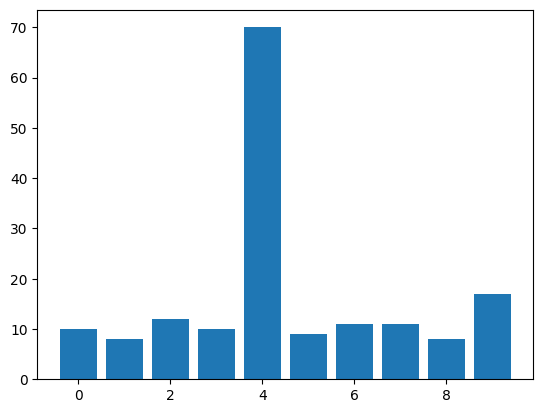

In [ ]:
categorias = ['0','R','5','4','3','2','1','E']
premios = {
    '0':0,
    'R':1,
    '5':8,
    '4':30,
    '3':1_050,
    '2':50_000,
    '1':1_300_000,
    'E':24_500_000
}
premios = pd.Series(premios)